In [1]:
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(4)

In [2]:
from __future__ import print_function
from rdkit.Chem.Draw import IPythonConsole, ReactionToImage, MolToImage, MolsToGridImage
from IPython.display import SVG, display, clear_output
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit import DataStructs
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import sys
sys.path.append('../../')
from retrosim.utils.draw import ReactionStringToImage, TransformStringToImage
from retrosim.utils.generate_retro_templates import process_an_example
from retrosim.data.get_data import get_data_df, split_data_df
from rdchiral.main import rdchiralRun, rdchiralReaction, rdchiralReactants

from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [3]:
data = get_data_df('../data/data_processed.csv')
split_data_df(data) # 80/10/10 within each class

15151 rows with class value 1
11896 rows with class value 2
5662 rows with class value 3
909 rows with class value 4
672 rows with class value 5
8237 rows with class value 6
4614 rows with class value 7
811 rows with class value 8
1834 rows with class value 9
230 rows with class value 10
train    40008
test      5007
val       5001
Name: dataset, dtype: int64


## Select one set of settings to test
(use the test_similiarity.py script to do the full set of experiments)

In [4]:
class_ = 1
similarity_metric = DataStructs.BulkTanimotoSimilarity # BulkDiceSimilarity or BulkTanimotoSimilarity
similarity_label = 'Tanimoto'
getfp = lambda smi: AllChem.GetMorganFingerprint(Chem.MolFromSmiles(smi), 2, useFeatures=False)
getfp_label = 'Morgan2noFeat'
dataset = 'val'
label = '{}_class{}_fp{}_sim{}'.format(
    dataset,
    class_,
    getfp_label,
    similarity_label,
)

### Only get new FPs if necessary - is a little slow

In [5]:
try:
    if prev_FP != getfp:
        raise NameError
except NameError:
    all_fps = []
    for smi in tqdm(data['prod_smiles']):
        all_fps.append(getfp(smi))
    data['prod_fp'] = all_fps
    prev_FP = getfp

100%|██████████| 50016/50016 [00:24<00:00, 2050.90it/s]


### Get the training data subset of the full data

In [6]:
if class_ != 'all':
    datasub = data.loc[data['class'] == class_].loc[data['dataset'] == 'train']
    datasub_val = data.loc[data['class'] == class_].loc[data['dataset'] == dataset]
else:
    datasub = data.loc[data['dataset'] == 'train']
    datasub_val = data.loc[data['dataset'] == dataset]
fps = list(datasub['prod_fp'])
print('Size of knowledge base: {}'.format(len(fps)))

Size of knowledge base: 12120


## Go through full validation/test data, define the function for processing

In [7]:
jx_cache = {}
draw = False
debug = False

def do_one(ix, draw=draw, debug=debug, max_prec=100):
    
    rec_for_printing = ''
    
    ex = Chem.MolFromSmiles(datasub_val['prod_smiles'][ix])
    rct = rdchiralReactants(datasub_val['prod_smiles'][ix])
    if draw: 
        print('Mol {}'.format(ix))
    if debug:
        rec_for_printing += datasub_val['prod_smiles'][ix] + '\n'
        rec_for_printing += 'True reaction:'
        rec_for_printing += datasub_val['rxn_smiles'][ix] + '\n'
    fp = datasub_val['prod_fp'][ix]
    
    sims = similarity_metric(fp, [fp_ for fp_ in datasub['prod_fp']])
    js = np.argsort(sims)[::-1]

    if draw: display(ReactionStringToImage(datasub_val['rxn_smiles'][ix]))
    
    prec_goal = Chem.MolFromSmiles(datasub_val['rxn_smiles'][ix].split('>')[0])
    [a.ClearProp('molAtomMapNumber') for a in prec_goal.GetAtoms()]
    prec_goal = Chem.MolToSmiles(prec_goal, True)
    
    # Sometimes stereochem takes another canonicalization...
    prec_goal = Chem.MolToSmiles(Chem.MolFromSmiles(prec_goal), True)
    if debug:
        rec_for_printing += 'prec_goal: {}\n'.format(prec_goal)
    # Get probability of precursors
    probs = {}
    
    for ji, j in enumerate(js[:max_prec]):
        jx = datasub.index[j]
        
        if draw:
            print('\n\n' + '-'*50 + '\n')
            print('RANK {} PRECEDENT'.format(ji+1))
            print('PRODUCT MATCH SCORE: {}'.format(sims[j]))
            display(ReactionStringToImage(datasub['rxn_smiles'][jx]))
        if debug:
            rec_for_printing += '\nReaction precedent {}, prod similarity {}\n'.format(
                ji+1, sims[j])
            rec_for_printing += '-> rxn_smiles {}\n'.format(datasub['rxn_smiles'][jx])
        if jx in jx_cache:
            (rxn, template, rcts_ref_fp) = jx_cache[jx]
        else:
            template = '(' + process_an_example(datasub['rxn_smiles'][jx], super_general=True).replace('>>', ')>>')
            rcts_ref_fp = getfp(datasub['rxn_smiles'][jx].split('>')[0])
            rxn = rdchiralReaction(template)
            jx_cache[jx] = (rxn, template, rcts_ref_fp)
        if debug:
            rec_for_printing += '-> template: {}\n'.format(template)
        if draw:
            print('-> template: {}'.format(template))
            
        try:
            outcomes = rdchiralRun(rxn, rct, combine_enantiomers=False)
        except Exception as e:
            print(e)
            outcomes = []

        if not outcomes and draw:
            print('No precursors could be generated!')
            
        for precursors in outcomes:
            precursors_fp = getfp(precursors)
            precursors_sim = similarity_metric(precursors_fp, [rcts_ref_fp])[0]
            if debug:
                rec_for_printing += 'prec sim {} smiles {}\n'.format(precursors_sim, precursors)
            if draw:
                print('Precursor similarity {}, overall {}, smiles {}'.format(
                    precursors_sim, precursors_sim*sims[j], precursors))
                display(MolToImage(Chem.MolFromSmiles(precursors)))
            if precursors in probs:
                probs[precursors] = max(probs[precursors], precursors_sim * sims[j])
            else:
                probs[precursors] = precursors_sim * sims[j]
    
    testlimit = 50
    mols = []
    legends = []

    found_rank = 9999
    for r, (prec, prob) in enumerate(sorted(probs.items(), key=lambda x:x[1], reverse=True)[:testlimit]):
        mols.append(Chem.MolFromSmiles(prec))
        if prec == prec_goal:
            found_rank = r + 1
            legends.append('[TRUE] {}'.format(prob))
        else:
            legends.append('{}'.format(prob))
            pass
    if found_rank == 9999 and debug:
        print(datasub_val['rxn_smiles'][ix])
        display(ReactionStringToImage(datasub_val['rxn_smiles'][ix]))
        print(prec_goal)
        draw = True
    
    if draw: 
        img=MolsToGridImage(mols[:9],molsPerRow=3,subImgSize=(300,300),legends=legends[:9])
        display(img)
        for mol in mols[:9]:
            print(Chem.MolToSmiles(mol, True))
    if debug:
        print(rec_for_printing)
    if draw or debug:
        raw_input('pause')
        clear_output()
        
    return found_rank

### Code for running one-at-a-time on a single core

In [8]:
found_at_rank = []
import collections
found_at_rank_counter = collections.defaultdict(int)

for ii, ix in enumerate(datasub_val.index):
        
    if ii % 1 == 0 and ii > 0:
        print('{} done'.format(ii))
        print('Current found_at_rank: {}'.format(found_at_rank_counter))
        
    found_rank = do_one(ix)
    found_at_rank.append(found_rank)
    found_at_rank_counter[found_rank] += 1

1 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 1})
2 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 1, 2: 1})
3 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 1, 2: 2})
4 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 2, 2: 2})
5 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 3, 2: 2})
6 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 3, 2: 2, 6: 1})
7 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 4, 2: 2, 6: 1})
8 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 4, 2: 3, 6: 1})
9 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 5, 2: 3, 6: 1})
10 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 6, 2: 3, 6: 1})
11 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 6, 2: 3, 6: 1, 9999: 1})
12 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 7, 2: 3, 6: 1, 9999: 1})
13 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 7, 2: 3, 6: 1, 9999: 2})
14 d

70 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 27, 2: 5, 6: 2, 9999: 6, 20: 1, 4: 5, 5: 3, 3: 9, 32: 1, 7: 6, 9: 3, 11: 1, 21: 1})
71 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 27, 2: 5, 6: 2, 9999: 7, 20: 1, 4: 5, 5: 3, 3: 9, 32: 1, 7: 6, 9: 3, 11: 1, 21: 1})
72 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 28, 2: 5, 6: 2, 9999: 7, 20: 1, 4: 5, 5: 3, 3: 9, 32: 1, 7: 6, 9: 3, 11: 1, 21: 1})
73 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 29, 2: 5, 6: 2, 9999: 7, 20: 1, 4: 5, 5: 3, 3: 9, 32: 1, 7: 6, 9: 3, 11: 1, 21: 1})
74 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 30, 2: 5, 6: 2, 9999: 7, 20: 1, 4: 5, 5: 3, 3: 9, 32: 1, 7: 6, 9: 3, 11: 1, 21: 1})
75 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 31, 2: 5, 6: 2, 9999: 7, 20: 1, 4: 5, 5: 3, 3: 9, 32: 1, 7: 6, 9: 3, 11: 1, 21: 1})
76 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 32, 2: 5, 6: 2, 9999: 7, 20: 1, 4: 5, 5: 3, 3: 9, 32: 1, 7: 6,

123 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 53, 2: 9, 6: 2, 9999: 11, 20: 1, 4: 9, 5: 7, 3: 14, 32: 1, 7: 6, 9: 3, 11: 1, 21: 1, 10: 3, 13: 1, 16: 1})
124 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 53, 2: 9, 6: 2, 9999: 11, 20: 1, 4: 9, 5: 7, 3: 15, 32: 1, 7: 6, 9: 3, 11: 1, 21: 1, 10: 3, 13: 1, 16: 1})
125 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 53, 2: 9, 6: 2, 9999: 11, 20: 1, 4: 9, 5: 7, 3: 16, 32: 1, 7: 6, 9: 3, 11: 1, 21: 1, 10: 3, 13: 1, 16: 1})
126 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 53, 2: 9, 6: 2, 9999: 11, 20: 1, 4: 9, 5: 7, 3: 16, 32: 1, 7: 6, 9: 3, 11: 1, 21: 1, 10: 3, 13: 1, 16: 1, 15: 1})
127 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 53, 2: 10, 6: 2, 9999: 11, 20: 1, 4: 9, 5: 7, 3: 16, 32: 1, 7: 6, 9: 3, 11: 1, 21: 1, 10: 3, 13: 1, 16: 1, 15: 1})
128 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 53, 2: 11, 6: 2, 9999: 11, 20: 1, 4: 9, 5: 7, 3: 16, 32: 1, 7: 6, 9: 3, 

171 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 76, 2: 18, 6: 4, 9999: 12, 20: 1, 4: 11, 5: 7, 3: 19, 32: 1, 7: 8, 9: 3, 11: 1, 21: 1, 10: 5, 13: 1, 16: 1, 15: 1, 8: 1})
172 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 76, 2: 18, 6: 4, 9999: 12, 20: 1, 4: 11, 5: 8, 3: 19, 32: 1, 7: 8, 9: 3, 11: 1, 21: 1, 10: 5, 13: 1, 16: 1, 15: 1, 8: 1})
173 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 76, 2: 18, 6: 4, 9999: 12, 20: 1, 4: 12, 5: 8, 3: 19, 32: 1, 7: 8, 9: 3, 11: 1, 21: 1, 10: 5, 13: 1, 16: 1, 15: 1, 8: 1})
174 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 76, 2: 19, 6: 4, 9999: 12, 20: 1, 4: 12, 5: 8, 3: 19, 32: 1, 7: 8, 9: 3, 11: 1, 21: 1, 10: 5, 13: 1, 16: 1, 15: 1, 8: 1})
175 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 76, 2: 19, 6: 4, 9999: 13, 20: 1, 4: 12, 5: 8, 3: 19, 32: 1, 7: 8, 9: 3, 11: 1, 21: 1, 10: 5, 13: 1, 16: 1, 15: 1, 8: 1})
176 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 76, 2: 19, 6

214 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 96, 2: 24, 6: 4, 9999: 16, 20: 1, 4: 15, 5: 8, 3: 22, 32: 1, 7: 9, 9: 5, 11: 1, 21: 1, 10: 5, 13: 1, 16: 1, 15: 1, 8: 1, 17: 1, 12: 1})
215 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 97, 2: 24, 6: 4, 9999: 16, 20: 1, 4: 15, 5: 8, 3: 22, 32: 1, 7: 9, 9: 5, 11: 1, 21: 1, 10: 5, 13: 1, 16: 1, 15: 1, 8: 1, 17: 1, 12: 1})
216 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 98, 2: 24, 6: 4, 9999: 16, 20: 1, 4: 15, 5: 8, 3: 22, 32: 1, 7: 9, 9: 5, 11: 1, 21: 1, 10: 5, 13: 1, 16: 1, 15: 1, 8: 1, 17: 1, 12: 1})
217 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 99, 2: 24, 6: 4, 9999: 16, 20: 1, 4: 15, 5: 8, 3: 22, 32: 1, 7: 9, 9: 5, 11: 1, 21: 1, 10: 5, 13: 1, 16: 1, 15: 1, 8: 1, 17: 1, 12: 1})
218 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 99, 2: 24, 6: 4, 9999: 16, 20: 1, 4: 15, 5: 9, 3: 22, 32: 1, 7: 9, 9: 5, 11: 1, 21: 1, 10: 5, 13: 1, 16: 1, 15: 1, 8: 1, 17: 1, 12: 1})
219 d

254 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 119, 2: 27, 6: 4, 9999: 19, 20: 1, 4: 17, 5: 11, 3: 23, 32: 1, 7: 11, 9: 5, 11: 1, 21: 1, 10: 6, 13: 1, 16: 1, 15: 1, 8: 1, 17: 1, 12: 2, 22: 1})
255 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 119, 2: 27, 6: 4, 9999: 19, 20: 1, 4: 17, 5: 11, 3: 23, 32: 1, 7: 11, 9: 5, 11: 1, 21: 1, 10: 6, 13: 1, 16: 2, 15: 1, 8: 1, 17: 1, 12: 2, 22: 1})
256 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 120, 2: 27, 6: 4, 9999: 19, 20: 1, 4: 17, 5: 11, 3: 23, 32: 1, 7: 11, 9: 5, 11: 1, 21: 1, 10: 6, 13: 1, 16: 2, 15: 1, 8: 1, 17: 1, 12: 2, 22: 1})
257 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 121, 2: 27, 6: 4, 9999: 19, 20: 1, 4: 17, 5: 11, 3: 23, 32: 1, 7: 11, 9: 5, 11: 1, 21: 1, 10: 6, 13: 1, 16: 2, 15: 1, 8: 1, 17: 1, 12: 2, 22: 1})
258 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 121, 2: 27, 6: 4, 9999: 19, 20: 1, 4: 17, 5: 11, 3: 23, 32: 1, 7: 12, 9: 5, 11: 1, 21: 1, 10: 6, 13: 

294 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 141, 2: 27, 6: 8, 9999: 23, 20: 1, 4: 18, 5: 13, 3: 27, 32: 1, 7: 13, 9: 5, 11: 1, 21: 1, 10: 6, 13: 1, 16: 2, 15: 1, 8: 1, 17: 1, 12: 2, 22: 1})
295 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 141, 2: 27, 6: 8, 9999: 23, 20: 1, 4: 19, 5: 13, 3: 27, 32: 1, 7: 13, 9: 5, 11: 1, 21: 1, 10: 6, 13: 1, 16: 2, 15: 1, 8: 1, 17: 1, 12: 2, 22: 1})
296 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 141, 2: 27, 6: 8, 9999: 24, 20: 1, 4: 19, 5: 13, 3: 27, 32: 1, 7: 13, 9: 5, 11: 1, 21: 1, 10: 6, 13: 1, 16: 2, 15: 1, 8: 1, 17: 1, 12: 2, 22: 1})
297 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 141, 2: 28, 6: 8, 9999: 24, 20: 1, 4: 19, 5: 13, 3: 27, 32: 1, 7: 13, 9: 5, 11: 1, 21: 1, 10: 6, 13: 1, 16: 2, 15: 1, 8: 1, 17: 1, 12: 2, 22: 1})
298 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 141, 2: 29, 6: 8, 9999: 24, 20: 1, 4: 19, 5: 13, 3: 27, 32: 1, 7: 13, 9: 5, 11: 1, 21: 1, 10: 6, 13: 

334 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 156, 2: 36, 6: 10, 9999: 27, 20: 1, 4: 22, 5: 15, 3: 29, 32: 1, 7: 13, 9: 6, 11: 1, 21: 1, 10: 6, 13: 1, 16: 2, 15: 2, 8: 1, 17: 1, 12: 2, 22: 1})
335 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 157, 2: 36, 6: 10, 9999: 27, 20: 1, 4: 22, 5: 15, 3: 29, 32: 1, 7: 13, 9: 6, 11: 1, 21: 1, 10: 6, 13: 1, 16: 2, 15: 2, 8: 1, 17: 1, 12: 2, 22: 1})
336 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 157, 2: 36, 6: 10, 9999: 27, 20: 1, 4: 22, 5: 15, 3: 30, 32: 1, 7: 13, 9: 6, 11: 1, 21: 1, 10: 6, 13: 1, 16: 2, 15: 2, 8: 1, 17: 1, 12: 2, 22: 1})
337 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 158, 2: 36, 6: 10, 9999: 27, 20: 1, 4: 22, 5: 15, 3: 30, 32: 1, 7: 13, 9: 6, 11: 1, 21: 1, 10: 6, 13: 1, 16: 2, 15: 2, 8: 1, 17: 1, 12: 2, 22: 1})
338 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 158, 2: 36, 6: 10, 9999: 28, 20: 1, 4: 22, 5: 15, 3: 30, 32: 1, 7: 13, 9: 6, 11: 1, 21: 1, 10: 6,

372 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 171, 2: 41, 6: 10, 9999: 33, 20: 1, 4: 23, 5: 16, 3: 30, 32: 1, 7: 15, 9: 6, 11: 2, 21: 1, 10: 6, 13: 1, 16: 4, 15: 2, 8: 1, 17: 1, 12: 4, 22: 1, 28: 1, 14: 1})
373 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 171, 2: 41, 6: 10, 9999: 34, 20: 1, 4: 23, 5: 16, 3: 30, 32: 1, 7: 15, 9: 6, 11: 2, 21: 1, 10: 6, 13: 1, 16: 4, 15: 2, 8: 1, 17: 1, 12: 4, 22: 1, 28: 1, 14: 1})
374 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 171, 2: 41, 6: 10, 9999: 34, 20: 1, 4: 23, 5: 16, 3: 31, 32: 1, 7: 15, 9: 6, 11: 2, 21: 1, 10: 6, 13: 1, 16: 4, 15: 2, 8: 1, 17: 1, 12: 4, 22: 1, 28: 1, 14: 1})
375 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 172, 2: 41, 6: 10, 9999: 34, 20: 1, 4: 23, 5: 16, 3: 31, 32: 1, 7: 15, 9: 6, 11: 2, 21: 1, 10: 6, 13: 1, 16: 4, 15: 2, 8: 1, 17: 1, 12: 4, 22: 1, 28: 1, 14: 1})
376 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 173, 2: 41, 6: 10, 9999: 34, 20: 1, 4: 23

409 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 192, 2: 45, 6: 10, 9999: 36, 20: 1, 4: 23, 5: 17, 3: 32, 32: 1, 7: 15, 9: 7, 11: 3, 21: 1, 10: 6, 13: 1, 16: 4, 15: 3, 8: 2, 17: 1, 12: 5, 22: 1, 28: 1, 14: 2})
410 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 193, 2: 45, 6: 10, 9999: 36, 20: 1, 4: 23, 5: 17, 3: 32, 32: 1, 7: 15, 9: 7, 11: 3, 21: 1, 10: 6, 13: 1, 16: 4, 15: 3, 8: 2, 17: 1, 12: 5, 22: 1, 28: 1, 14: 2})
411 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 193, 2: 46, 6: 10, 9999: 36, 20: 1, 4: 23, 5: 17, 3: 32, 32: 1, 7: 15, 9: 7, 11: 3, 21: 1, 10: 6, 13: 1, 16: 4, 15: 3, 8: 2, 17: 1, 12: 5, 22: 1, 28: 1, 14: 2})
412 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 193, 2: 47, 6: 10, 9999: 36, 20: 1, 4: 23, 5: 17, 3: 32, 32: 1, 7: 15, 9: 7, 11: 3, 21: 1, 10: 6, 13: 1, 16: 4, 15: 3, 8: 2, 17: 1, 12: 5, 22: 1, 28: 1, 14: 2})
413 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 194, 2: 47, 6: 10, 9999: 36, 20: 1, 4: 23

446 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 208, 2: 52, 6: 10, 9999: 40, 20: 1, 4: 24, 5: 20, 3: 34, 32: 1, 7: 17, 9: 7, 11: 3, 21: 1, 10: 7, 13: 1, 16: 4, 15: 3, 8: 2, 17: 1, 12: 5, 22: 1, 28: 1, 14: 2, 29: 1})
447 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 208, 2: 53, 6: 10, 9999: 40, 20: 1, 4: 24, 5: 20, 3: 34, 32: 1, 7: 17, 9: 7, 11: 3, 21: 1, 10: 7, 13: 1, 16: 4, 15: 3, 8: 2, 17: 1, 12: 5, 22: 1, 28: 1, 14: 2, 29: 1})
448 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 208, 2: 53, 6: 10, 9999: 40, 20: 1, 4: 24, 5: 20, 3: 34, 32: 1, 7: 17, 9: 7, 11: 3, 21: 1, 10: 7, 13: 1, 16: 4, 15: 3, 8: 3, 17: 1, 12: 5, 22: 1, 28: 1, 14: 2, 29: 1})
449 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 208, 2: 53, 6: 10, 9999: 40, 20: 1, 4: 24, 5: 20, 3: 34, 32: 1, 7: 17, 9: 8, 11: 3, 21: 1, 10: 7, 13: 1, 16: 4, 15: 3, 8: 3, 17: 1, 12: 5, 22: 1, 28: 1, 14: 2, 29: 1})
450 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 209, 2: 53, 6

482 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 216, 2: 62, 6: 12, 9999: 43, 20: 1, 4: 28, 5: 21, 3: 37, 32: 1, 7: 18, 9: 9, 11: 3, 21: 1, 10: 7, 13: 1, 16: 4, 15: 3, 8: 3, 17: 1, 12: 5, 22: 1, 28: 1, 14: 3, 29: 1})
483 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 217, 2: 62, 6: 12, 9999: 43, 20: 1, 4: 28, 5: 21, 3: 37, 32: 1, 7: 18, 9: 9, 11: 3, 21: 1, 10: 7, 13: 1, 16: 4, 15: 3, 8: 3, 17: 1, 12: 5, 22: 1, 28: 1, 14: 3, 29: 1})
484 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 218, 2: 62, 6: 12, 9999: 43, 20: 1, 4: 28, 5: 21, 3: 37, 32: 1, 7: 18, 9: 9, 11: 3, 21: 1, 10: 7, 13: 1, 16: 4, 15: 3, 8: 3, 17: 1, 12: 5, 22: 1, 28: 1, 14: 3, 29: 1})
485 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 218, 2: 62, 6: 12, 9999: 43, 20: 1, 4: 28, 5: 22, 3: 37, 32: 1, 7: 18, 9: 9, 11: 3, 21: 1, 10: 7, 13: 1, 16: 4, 15: 3, 8: 3, 17: 1, 12: 5, 22: 1, 28: 1, 14: 3, 29: 1})
486 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 219, 2: 62, 6

518 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 234, 2: 66, 6: 13, 9999: 44, 20: 2, 4: 30, 5: 22, 3: 38, 32: 1, 7: 19, 9: 12, 11: 3, 21: 1, 10: 8, 13: 1, 16: 4, 15: 3, 8: 3, 17: 1, 12: 6, 22: 1, 28: 2, 14: 3, 29: 1})
519 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 234, 2: 66, 6: 13, 9999: 44, 20: 2, 4: 30, 5: 22, 3: 38, 32: 1, 7: 19, 9: 13, 11: 3, 21: 1, 10: 8, 13: 1, 16: 4, 15: 3, 8: 3, 17: 1, 12: 6, 22: 1, 28: 2, 14: 3, 29: 1})
520 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 235, 2: 66, 6: 13, 9999: 44, 20: 2, 4: 30, 5: 22, 3: 38, 32: 1, 7: 19, 9: 13, 11: 3, 21: 1, 10: 8, 13: 1, 16: 4, 15: 3, 8: 3, 17: 1, 12: 6, 22: 1, 28: 2, 14: 3, 29: 1})
521 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 235, 2: 66, 6: 13, 9999: 44, 20: 2, 4: 30, 5: 22, 3: 39, 32: 1, 7: 19, 9: 13, 11: 3, 21: 1, 10: 8, 13: 1, 16: 4, 15: 3, 8: 3, 17: 1, 12: 6, 22: 1, 28: 2, 14: 3, 29: 1})
522 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 236, 2: 6

554 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 251, 2: 69, 6: 14, 9999: 47, 20: 2, 4: 33, 5: 23, 3: 40, 32: 1, 7: 20, 9: 14, 11: 4, 21: 1, 10: 10, 13: 1, 16: 4, 15: 3, 8: 3, 17: 1, 12: 6, 22: 1, 28: 2, 14: 3, 29: 1})
555 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 251, 2: 69, 6: 14, 9999: 47, 20: 2, 4: 33, 5: 23, 3: 40, 32: 1, 7: 20, 9: 14, 11: 4, 21: 1, 10: 10, 13: 1, 16: 4, 15: 3, 8: 3, 17: 1, 12: 6, 22: 1, 28: 2, 14: 4, 29: 1})
556 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 252, 2: 69, 6: 14, 9999: 47, 20: 2, 4: 33, 5: 23, 3: 40, 32: 1, 7: 20, 9: 14, 11: 4, 21: 1, 10: 10, 13: 1, 16: 4, 15: 3, 8: 3, 17: 1, 12: 6, 22: 1, 28: 2, 14: 4, 29: 1})
557 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 253, 2: 69, 6: 14, 9999: 47, 20: 2, 4: 33, 5: 23, 3: 40, 32: 1, 7: 20, 9: 14, 11: 4, 21: 1, 10: 10, 13: 1, 16: 4, 15: 3, 8: 3, 17: 1, 12: 6, 22: 1, 28: 2, 14: 4, 29: 1})
558 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 253, 

590 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 273, 2: 71, 6: 15, 9999: 50, 20: 2, 4: 34, 5: 25, 3: 42, 32: 1, 7: 20, 9: 14, 11: 5, 21: 1, 10: 10, 13: 2, 16: 4, 15: 3, 8: 3, 17: 1, 12: 6, 22: 1, 28: 2, 14: 4, 29: 1})
591 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 274, 2: 71, 6: 15, 9999: 50, 20: 2, 4: 34, 5: 25, 3: 42, 32: 1, 7: 20, 9: 14, 11: 5, 21: 1, 10: 10, 13: 2, 16: 4, 15: 3, 8: 3, 17: 1, 12: 6, 22: 1, 28: 2, 14: 4, 29: 1})
592 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 275, 2: 71, 6: 15, 9999: 50, 20: 2, 4: 34, 5: 25, 3: 42, 32: 1, 7: 20, 9: 14, 11: 5, 21: 1, 10: 10, 13: 2, 16: 4, 15: 3, 8: 3, 17: 1, 12: 6, 22: 1, 28: 2, 14: 4, 29: 1})
593 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 276, 2: 71, 6: 15, 9999: 50, 20: 2, 4: 34, 5: 25, 3: 42, 32: 1, 7: 20, 9: 14, 11: 5, 21: 1, 10: 10, 13: 2, 16: 4, 15: 3, 8: 3, 17: 1, 12: 6, 22: 1, 28: 2, 14: 4, 29: 1})
594 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 276, 

625 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 289, 2: 78, 6: 16, 9999: 54, 20: 2, 4: 35, 5: 25, 3: 45, 32: 1, 7: 20, 9: 14, 11: 5, 21: 1, 10: 10, 13: 2, 16: 4, 15: 3, 8: 3, 17: 1, 12: 8, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1})
626 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 289, 2: 78, 6: 16, 9999: 54, 20: 2, 4: 35, 5: 25, 3: 46, 32: 1, 7: 20, 9: 14, 11: 5, 21: 1, 10: 10, 13: 2, 16: 4, 15: 3, 8: 3, 17: 1, 12: 8, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1})
627 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 290, 2: 78, 6: 16, 9999: 54, 20: 2, 4: 35, 5: 25, 3: 46, 32: 1, 7: 20, 9: 14, 11: 5, 21: 1, 10: 10, 13: 2, 16: 4, 15: 3, 8: 3, 17: 1, 12: 8, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1})
628 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 290, 2: 78, 6: 16, 9999: 55, 20: 2, 4: 35, 5: 25, 3: 46, 32: 1, 7: 20, 9: 14, 11: 5, 21: 1, 10: 10, 13: 2, 16: 4, 15: 3, 8: 3, 17: 1, 12: 8, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1})
629 done
Current found_at_rank: defaultd

660 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 307, 2: 81, 6: 17, 9999: 57, 20: 2, 4: 36, 5: 28, 3: 49, 32: 1, 7: 20, 9: 14, 11: 5, 21: 1, 10: 10, 13: 2, 16: 4, 15: 3, 8: 4, 17: 1, 12: 8, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
661 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 307, 2: 81, 6: 17, 9999: 57, 20: 2, 4: 36, 5: 28, 3: 49, 32: 1, 7: 20, 9: 14, 11: 5, 21: 1, 10: 10, 13: 3, 16: 4, 15: 3, 8: 4, 17: 1, 12: 8, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
662 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 308, 2: 81, 6: 17, 9999: 57, 20: 2, 4: 36, 5: 28, 3: 49, 32: 1, 7: 20, 9: 14, 11: 5, 21: 1, 10: 10, 13: 3, 16: 4, 15: 3, 8: 4, 17: 1, 12: 8, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
663 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 308, 2: 81, 6: 17, 9999: 57, 20: 2, 4: 36, 5: 28, 3: 49, 32: 1, 7: 20, 9: 14, 11: 5, 21: 1, 10: 10, 13: 3, 16: 4, 15: 3, 8: 5, 17: 1, 12: 8, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
664 done
Cur

694 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 322, 2: 85, 6: 17, 9999: 61, 20: 2, 4: 38, 5: 29, 3: 50, 32: 1, 7: 21, 9: 15, 11: 5, 21: 1, 10: 11, 13: 3, 16: 4, 15: 3, 8: 7, 17: 1, 12: 8, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
695 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 322, 2: 85, 6: 17, 9999: 61, 20: 2, 4: 38, 5: 29, 3: 50, 32: 1, 7: 21, 9: 15, 11: 5, 21: 1, 10: 11, 13: 3, 16: 4, 15: 3, 8: 7, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
696 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 323, 2: 85, 6: 17, 9999: 61, 20: 2, 4: 38, 5: 29, 3: 50, 32: 1, 7: 21, 9: 15, 11: 5, 21: 1, 10: 11, 13: 3, 16: 4, 15: 3, 8: 7, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
697 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 324, 2: 85, 6: 17, 9999: 61, 20: 2, 4: 38, 5: 29, 3: 50, 32: 1, 7: 21, 9: 15, 11: 5, 21: 1, 10: 11, 13: 3, 16: 4, 15: 3, 8: 7, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
698 done
Cur

728 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 344, 2: 87, 6: 19, 9999: 65, 20: 2, 4: 39, 5: 29, 3: 51, 32: 1, 7: 21, 9: 15, 11: 6, 21: 1, 10: 11, 13: 3, 16: 4, 15: 3, 8: 7, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
729 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 344, 2: 88, 6: 19, 9999: 65, 20: 2, 4: 39, 5: 29, 3: 51, 32: 1, 7: 21, 9: 15, 11: 6, 21: 1, 10: 11, 13: 3, 16: 4, 15: 3, 8: 7, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
730 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 344, 2: 88, 6: 19, 9999: 65, 20: 2, 4: 40, 5: 29, 3: 51, 32: 1, 7: 21, 9: 15, 11: 6, 21: 1, 10: 11, 13: 3, 16: 4, 15: 3, 8: 7, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
731 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 345, 2: 88, 6: 19, 9999: 65, 20: 2, 4: 40, 5: 29, 3: 51, 32: 1, 7: 21, 9: 15, 11: 6, 21: 1, 10: 11, 13: 3, 16: 4, 15: 3, 8: 7, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
732 done
Cur

762 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 363, 2: 89, 6: 20, 9999: 69, 20: 2, 4: 40, 5: 29, 3: 52, 32: 1, 7: 23, 9: 17, 11: 7, 21: 1, 10: 11, 13: 3, 16: 4, 15: 3, 8: 8, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
763 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 363, 2: 89, 6: 20, 9999: 69, 20: 2, 4: 40, 5: 29, 3: 53, 32: 1, 7: 23, 9: 17, 11: 7, 21: 1, 10: 11, 13: 3, 16: 4, 15: 3, 8: 8, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
764 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 363, 2: 89, 6: 20, 9999: 69, 20: 2, 4: 40, 5: 29, 3: 53, 32: 1, 7: 24, 9: 17, 11: 7, 21: 1, 10: 11, 13: 3, 16: 4, 15: 3, 8: 8, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
765 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 364, 2: 89, 6: 20, 9999: 69, 20: 2, 4: 40, 5: 29, 3: 53, 32: 1, 7: 24, 9: 17, 11: 7, 21: 1, 10: 11, 13: 3, 16: 4, 15: 3, 8: 8, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
766 done
Cur

796 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 380, 2: 91, 6: 20, 9999: 70, 20: 2, 4: 44, 5: 30, 3: 57, 32: 1, 7: 26, 9: 17, 11: 8, 21: 1, 10: 11, 13: 3, 16: 4, 15: 3, 8: 8, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
797 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 380, 2: 92, 6: 20, 9999: 70, 20: 2, 4: 44, 5: 30, 3: 57, 32: 1, 7: 26, 9: 17, 11: 8, 21: 1, 10: 11, 13: 3, 16: 4, 15: 3, 8: 8, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
798 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 381, 2: 92, 6: 20, 9999: 70, 20: 2, 4: 44, 5: 30, 3: 57, 32: 1, 7: 26, 9: 17, 11: 8, 21: 1, 10: 11, 13: 3, 16: 4, 15: 3, 8: 8, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
799 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 381, 2: 93, 6: 20, 9999: 70, 20: 2, 4: 44, 5: 30, 3: 57, 32: 1, 7: 26, 9: 17, 11: 8, 21: 1, 10: 11, 13: 3, 16: 4, 15: 3, 8: 8, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
800 done
Cur

830 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 395, 2: 99, 6: 21, 9999: 73, 20: 2, 4: 44, 5: 31, 3: 58, 32: 1, 7: 28, 9: 19, 11: 8, 21: 1, 10: 11, 13: 3, 16: 5, 15: 3, 8: 8, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
831 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 396, 2: 99, 6: 21, 9999: 73, 20: 2, 4: 44, 5: 31, 3: 58, 32: 1, 7: 28, 9: 19, 11: 8, 21: 1, 10: 11, 13: 3, 16: 5, 15: 3, 8: 8, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
832 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 396, 2: 99, 6: 22, 9999: 73, 20: 2, 4: 44, 5: 31, 3: 58, 32: 1, 7: 28, 9: 19, 11: 8, 21: 1, 10: 11, 13: 3, 16: 5, 15: 3, 8: 8, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
833 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 397, 2: 99, 6: 22, 9999: 73, 20: 2, 4: 44, 5: 31, 3: 58, 32: 1, 7: 28, 9: 19, 11: 8, 21: 1, 10: 11, 13: 3, 16: 5, 15: 3, 8: 8, 17: 1, 12: 9, 22: 1, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
834 done
Cur

864 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 408, 2: 106, 6: 22, 9999: 74, 20: 2, 4: 45, 5: 33, 3: 61, 32: 1, 7: 28, 9: 20, 11: 9, 21: 1, 10: 11, 13: 3, 16: 5, 15: 3, 8: 10, 17: 1, 12: 9, 22: 3, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
865 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 409, 2: 106, 6: 22, 9999: 74, 20: 2, 4: 45, 5: 33, 3: 61, 32: 1, 7: 28, 9: 20, 11: 9, 21: 1, 10: 11, 13: 3, 16: 5, 15: 3, 8: 10, 17: 1, 12: 9, 22: 3, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
866 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 409, 2: 107, 6: 22, 9999: 74, 20: 2, 4: 45, 5: 33, 3: 61, 32: 1, 7: 28, 9: 20, 11: 9, 21: 1, 10: 11, 13: 3, 16: 5, 15: 3, 8: 10, 17: 1, 12: 9, 22: 3, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
867 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 410, 2: 107, 6: 22, 9999: 74, 20: 2, 4: 45, 5: 33, 3: 61, 32: 1, 7: 28, 9: 20, 11: 9, 21: 1, 10: 11, 13: 3, 16: 5, 15: 3, 8: 10, 17: 1, 12: 9, 22: 3, 28: 2, 14: 4, 29: 1, 18: 1, 24: 1})
868 

897 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 422, 2: 114, 6: 22, 9999: 75, 20: 2, 4: 47, 5: 34, 3: 63, 32: 1, 7: 29, 9: 20, 11: 10, 21: 1, 10: 11, 13: 3, 16: 5, 15: 4, 8: 11, 17: 1, 12: 9, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1})
898 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 423, 2: 114, 6: 22, 9999: 75, 20: 2, 4: 47, 5: 34, 3: 63, 32: 1, 7: 29, 9: 20, 11: 10, 21: 1, 10: 11, 13: 3, 16: 5, 15: 4, 8: 11, 17: 1, 12: 9, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1})
899 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 424, 2: 114, 6: 22, 9999: 75, 20: 2, 4: 47, 5: 34, 3: 63, 32: 1, 7: 29, 9: 20, 11: 10, 21: 1, 10: 11, 13: 3, 16: 5, 15: 4, 8: 11, 17: 1, 12: 9, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1})
900 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 424, 2: 114, 6: 22, 9999: 75, 20: 2, 4: 47, 5: 34, 3: 63, 32: 1, 7: 29, 9: 20, 11: 10, 21: 1, 10: 11, 13: 3, 16: 5, 15: 4, 8: 12, 17: 1, 12: 9, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1})


930 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 438, 2: 119, 6: 23, 9999: 76, 20: 2, 4: 49, 5: 35, 3: 66, 32: 1, 7: 29, 9: 21, 11: 10, 21: 1, 10: 11, 13: 4, 16: 5, 15: 4, 8: 12, 17: 2, 12: 9, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1})
931 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 439, 2: 119, 6: 23, 9999: 76, 20: 2, 4: 49, 5: 35, 3: 66, 32: 1, 7: 29, 9: 21, 11: 10, 21: 1, 10: 11, 13: 4, 16: 5, 15: 4, 8: 12, 17: 2, 12: 9, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1})
932 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 439, 2: 119, 6: 24, 9999: 76, 20: 2, 4: 49, 5: 35, 3: 66, 32: 1, 7: 29, 9: 21, 11: 10, 21: 1, 10: 11, 13: 4, 16: 5, 15: 4, 8: 12, 17: 2, 12: 9, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1})
933 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 439, 2: 120, 6: 24, 9999: 76, 20: 2, 4: 49, 5: 35, 3: 66, 32: 1, 7: 29, 9: 21, 11: 10, 21: 1, 10: 11, 13: 4, 16: 5, 15: 4, 8: 12, 17: 2, 12: 9, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1})


963 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 454, 2: 126, 6: 25, 9999: 79, 20: 2, 4: 49, 5: 36, 3: 69, 32: 1, 7: 29, 9: 21, 11: 10, 21: 1, 10: 11, 13: 4, 16: 6, 15: 4, 8: 12, 17: 2, 12: 9, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1})
964 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 454, 2: 126, 6: 25, 9999: 80, 20: 2, 4: 49, 5: 36, 3: 69, 32: 1, 7: 29, 9: 21, 11: 10, 21: 1, 10: 11, 13: 4, 16: 6, 15: 4, 8: 12, 17: 2, 12: 9, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1})
965 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 454, 2: 126, 6: 25, 9999: 80, 20: 2, 4: 49, 5: 36, 3: 69, 32: 1, 7: 29, 9: 21, 11: 10, 21: 1, 10: 11, 13: 5, 16: 6, 15: 4, 8: 12, 17: 2, 12: 9, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1})
966 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 455, 2: 126, 6: 25, 9999: 80, 20: 2, 4: 49, 5: 36, 3: 69, 32: 1, 7: 29, 9: 21, 11: 10, 21: 1, 10: 11, 13: 5, 16: 6, 15: 4, 8: 12, 17: 2, 12: 9, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1})


997 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 471, 2: 127, 6: 25, 9999: 81, 20: 2, 4: 49, 5: 37, 3: 74, 32: 1, 7: 29, 9: 21, 11: 11, 21: 1, 10: 12, 13: 5, 16: 6, 15: 6, 8: 13, 17: 2, 12: 10, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1})
998 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 472, 2: 127, 6: 25, 9999: 81, 20: 2, 4: 49, 5: 37, 3: 74, 32: 1, 7: 29, 9: 21, 11: 11, 21: 1, 10: 12, 13: 5, 16: 6, 15: 6, 8: 13, 17: 2, 12: 10, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1})
999 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 473, 2: 127, 6: 25, 9999: 81, 20: 2, 4: 49, 5: 37, 3: 74, 32: 1, 7: 29, 9: 21, 11: 11, 21: 1, 10: 12, 13: 5, 16: 6, 15: 6, 8: 13, 17: 2, 12: 10, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1})
1000 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 474, 2: 127, 6: 25, 9999: 81, 20: 2, 4: 49, 5: 37, 3: 74, 32: 1, 7: 29, 9: 21, 11: 11, 21: 1, 10: 12, 13: 5, 16: 6, 15: 6, 8: 13, 17: 2, 12: 10, 22: 3, 28: 2, 14:

1029 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 487, 2: 133, 6: 26, 9999: 82, 20: 2, 4: 49, 5: 38, 3: 76, 32: 1, 7: 32, 9: 21, 11: 11, 21: 1, 10: 12, 13: 6, 16: 6, 15: 6, 8: 14, 17: 2, 12: 10, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1})
1030 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 487, 2: 133, 6: 26, 9999: 82, 20: 2, 4: 50, 5: 38, 3: 76, 32: 1, 7: 32, 9: 21, 11: 11, 21: 1, 10: 12, 13: 6, 16: 6, 15: 6, 8: 14, 17: 2, 12: 10, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1})
1031 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 488, 2: 133, 6: 26, 9999: 82, 20: 2, 4: 50, 5: 38, 3: 76, 32: 1, 7: 32, 9: 21, 11: 11, 21: 1, 10: 12, 13: 6, 16: 6, 15: 6, 8: 14, 17: 2, 12: 10, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1})
1032 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 488, 2: 134, 6: 26, 9999: 82, 20: 2, 4: 50, 5: 38, 3: 76, 32: 1, 7: 32, 9: 21, 11: 11, 21: 1, 10: 12, 13: 6, 16: 6, 15: 6, 8: 14, 17: 2, 12: 10, 22: 3, 28: 2, 

1061 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 501, 2: 137, 6: 26, 9999: 86, 20: 3, 4: 51, 5: 39, 3: 79, 32: 1, 7: 32, 9: 23, 11: 12, 21: 1, 10: 12, 13: 6, 16: 6, 15: 6, 8: 14, 17: 2, 12: 10, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1})
1062 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 501, 2: 137, 6: 26, 9999: 86, 20: 3, 4: 51, 5: 39, 3: 79, 32: 1, 7: 32, 9: 23, 11: 12, 21: 1, 10: 13, 13: 6, 16: 6, 15: 6, 8: 14, 17: 2, 12: 10, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1})
1063 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 501, 2: 138, 6: 26, 9999: 86, 20: 3, 4: 51, 5: 39, 3: 79, 32: 1, 7: 32, 9: 23, 11: 12, 21: 1, 10: 13, 13: 6, 16: 6, 15: 6, 8: 14, 17: 2, 12: 10, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1})
1064 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 502, 2: 138, 6: 26, 9999: 86, 20: 3, 4: 51, 5: 39, 3: 79, 32: 1, 7: 32, 9: 23, 11: 12, 21: 1, 10: 13, 13: 6, 16: 6, 15: 6, 8: 14, 17: 2, 12: 10, 22: 3, 28: 2, 

1093 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 520, 2: 138, 6: 27, 9999: 88, 20: 4, 4: 52, 5: 40, 3: 80, 32: 1, 7: 32, 9: 24, 11: 14, 21: 1, 10: 13, 13: 6, 16: 6, 15: 6, 8: 14, 17: 2, 12: 10, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1094 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 520, 2: 138, 6: 28, 9999: 88, 20: 4, 4: 52, 5: 40, 3: 80, 32: 1, 7: 32, 9: 24, 11: 14, 21: 1, 10: 13, 13: 6, 16: 6, 15: 6, 8: 14, 17: 2, 12: 10, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1095 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 520, 2: 138, 6: 28, 9999: 89, 20: 4, 4: 52, 5: 40, 3: 80, 32: 1, 7: 32, 9: 24, 11: 14, 21: 1, 10: 13, 13: 6, 16: 6, 15: 6, 8: 14, 17: 2, 12: 10, 22: 3, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1096 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 520, 2: 138, 6: 28, 9999: 89, 20: 4, 4: 52, 5: 40, 3: 80, 32: 1, 7: 32, 9: 24, 11: 14, 21: 1, 10: 13, 13: 6, 16: 6, 15: 7, 8: 14, 17: 2, 1

1125 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 532, 2: 144, 6: 29, 9999: 89, 20: 4, 4: 52, 5: 42, 3: 81, 32: 1, 7: 33, 9: 25, 11: 14, 21: 1, 10: 13, 13: 6, 16: 6, 15: 7, 8: 17, 17: 2, 12: 11, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1126 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 533, 2: 144, 6: 29, 9999: 89, 20: 4, 4: 52, 5: 42, 3: 81, 32: 1, 7: 33, 9: 25, 11: 14, 21: 1, 10: 13, 13: 6, 16: 6, 15: 7, 8: 17, 17: 2, 12: 11, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1127 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 534, 2: 144, 6: 29, 9999: 89, 20: 4, 4: 52, 5: 42, 3: 81, 32: 1, 7: 33, 9: 25, 11: 14, 21: 1, 10: 13, 13: 6, 16: 6, 15: 7, 8: 17, 17: 2, 12: 11, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1128 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 534, 2: 144, 6: 29, 9999: 89, 20: 4, 4: 53, 5: 42, 3: 81, 32: 1, 7: 33, 9: 25, 11: 14, 21: 1, 10: 13, 13: 6, 16: 6, 15: 7, 8: 17, 17: 2, 1

1156 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 548, 2: 145, 6: 29, 9999: 89, 20: 4, 4: 55, 5: 45, 3: 83, 32: 1, 7: 35, 9: 26, 11: 14, 21: 1, 10: 14, 13: 6, 16: 6, 15: 7, 8: 18, 17: 2, 12: 12, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1157 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 549, 2: 145, 6: 29, 9999: 89, 20: 4, 4: 55, 5: 45, 3: 83, 32: 1, 7: 35, 9: 26, 11: 14, 21: 1, 10: 14, 13: 6, 16: 6, 15: 7, 8: 18, 17: 2, 12: 12, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1158 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 550, 2: 145, 6: 29, 9999: 89, 20: 4, 4: 55, 5: 45, 3: 83, 32: 1, 7: 35, 9: 26, 11: 14, 21: 1, 10: 14, 13: 6, 16: 6, 15: 7, 8: 18, 17: 2, 12: 12, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1159 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 551, 2: 145, 6: 29, 9999: 89, 20: 4, 4: 55, 5: 45, 3: 83, 32: 1, 7: 35, 9: 26, 11: 14, 21: 1, 10: 14, 13: 6, 16: 6, 15: 7, 8: 18, 17: 2, 1

1187 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 571, 2: 149, 6: 29, 9999: 89, 20: 4, 4: 56, 5: 46, 3: 84, 32: 1, 7: 35, 9: 26, 11: 14, 21: 1, 10: 14, 13: 7, 16: 6, 15: 7, 8: 18, 17: 2, 12: 12, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1188 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 572, 2: 149, 6: 29, 9999: 89, 20: 4, 4: 56, 5: 46, 3: 84, 32: 1, 7: 35, 9: 26, 11: 14, 21: 1, 10: 14, 13: 7, 16: 6, 15: 7, 8: 18, 17: 2, 12: 12, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1189 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 573, 2: 149, 6: 29, 9999: 89, 20: 4, 4: 56, 5: 46, 3: 84, 32: 1, 7: 35, 9: 26, 11: 14, 21: 1, 10: 14, 13: 7, 16: 6, 15: 7, 8: 18, 17: 2, 12: 12, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1190 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 573, 2: 150, 6: 29, 9999: 89, 20: 4, 4: 56, 5: 46, 3: 84, 32: 1, 7: 35, 9: 26, 11: 14, 21: 1, 10: 14, 13: 7, 16: 6, 15: 7, 8: 18, 17: 2, 1

1218 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 589, 2: 153, 6: 29, 9999: 90, 20: 4, 4: 57, 5: 46, 3: 87, 32: 1, 7: 35, 9: 26, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 7, 8: 20, 17: 2, 12: 13, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1219 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 589, 2: 153, 6: 29, 9999: 90, 20: 4, 4: 58, 5: 46, 3: 87, 32: 1, 7: 35, 9: 26, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 7, 8: 20, 17: 2, 12: 13, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1220 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 590, 2: 153, 6: 29, 9999: 90, 20: 4, 4: 58, 5: 46, 3: 87, 32: 1, 7: 35, 9: 26, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 7, 8: 20, 17: 2, 12: 13, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1221 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 590, 2: 153, 6: 29, 9999: 90, 20: 4, 4: 58, 5: 46, 3: 88, 32: 1, 7: 35, 9: 26, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 7, 8: 20, 17: 2, 1

1249 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 605, 2: 155, 6: 29, 9999: 92, 20: 4, 4: 60, 5: 48, 3: 89, 32: 1, 7: 37, 9: 27, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 7, 8: 21, 17: 2, 12: 13, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1250 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 605, 2: 155, 6: 29, 9999: 92, 20: 4, 4: 61, 5: 48, 3: 89, 32: 1, 7: 37, 9: 27, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 7, 8: 21, 17: 2, 12: 13, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1251 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 606, 2: 155, 6: 29, 9999: 92, 20: 4, 4: 61, 5: 48, 3: 89, 32: 1, 7: 37, 9: 27, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 7, 8: 21, 17: 2, 12: 13, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1252 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 606, 2: 156, 6: 29, 9999: 92, 20: 4, 4: 61, 5: 48, 3: 89, 32: 1, 7: 37, 9: 27, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 7, 8: 21, 17: 2, 1

1280 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 623, 2: 160, 6: 31, 9999: 93, 20: 4, 4: 63, 5: 48, 3: 90, 32: 1, 7: 37, 9: 27, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 7, 8: 21, 17: 2, 12: 14, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1281 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 624, 2: 160, 6: 31, 9999: 93, 20: 4, 4: 63, 5: 48, 3: 90, 32: 1, 7: 37, 9: 27, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 7, 8: 21, 17: 2, 12: 14, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1282 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 624, 2: 161, 6: 31, 9999: 93, 20: 4, 4: 63, 5: 48, 3: 90, 32: 1, 7: 37, 9: 27, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 7, 8: 21, 17: 2, 12: 14, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1283 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 624, 2: 162, 6: 31, 9999: 93, 20: 4, 4: 63, 5: 48, 3: 90, 32: 1, 7: 37, 9: 27, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 7, 8: 21, 17: 2, 1

1311 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 637, 2: 165, 6: 32, 9999: 98, 20: 4, 4: 65, 5: 48, 3: 91, 32: 1, 7: 37, 9: 27, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 8, 8: 22, 17: 2, 12: 15, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1312 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 638, 2: 165, 6: 32, 9999: 98, 20: 4, 4: 65, 5: 48, 3: 91, 32: 1, 7: 37, 9: 27, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 8, 8: 22, 17: 2, 12: 15, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1313 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 638, 2: 165, 6: 32, 9999: 99, 20: 4, 4: 65, 5: 48, 3: 91, 32: 1, 7: 37, 9: 27, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 8, 8: 22, 17: 2, 12: 15, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1314 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 638, 2: 166, 6: 32, 9999: 99, 20: 4, 4: 65, 5: 48, 3: 91, 32: 1, 7: 37, 9: 27, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 8, 8: 22, 17: 2, 1

1342 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 655, 2: 169, 6: 33, 9999: 101, 20: 4, 4: 67, 5: 48, 3: 91, 32: 1, 7: 37, 9: 28, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 8, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1343 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 655, 2: 169, 6: 34, 9999: 101, 20: 4, 4: 67, 5: 48, 3: 91, 32: 1, 7: 37, 9: 28, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 8, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1344 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 656, 2: 169, 6: 34, 9999: 101, 20: 4, 4: 67, 5: 48, 3: 91, 32: 1, 7: 37, 9: 28, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 8, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 1, 27: 1, 19: 1})
1345 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 656, 2: 169, 6: 34, 9999: 101, 20: 4, 4: 67, 5: 48, 3: 92, 32: 1, 7: 37, 9: 28, 11: 15, 21: 1, 10: 14, 13: 7, 16: 6, 15: 8, 8: 23, 17: 

1374 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 671, 2: 173, 6: 34, 9999: 104, 20: 4, 4: 69, 5: 48, 3: 93, 32: 1, 7: 38, 9: 28, 11: 16, 21: 1, 10: 14, 13: 7, 16: 6, 15: 9, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 2, 27: 1, 19: 1})
1375 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 671, 2: 174, 6: 34, 9999: 104, 20: 4, 4: 69, 5: 48, 3: 93, 32: 1, 7: 38, 9: 28, 11: 16, 21: 1, 10: 14, 13: 7, 16: 6, 15: 9, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 2, 27: 1, 19: 1})
1376 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 671, 2: 175, 6: 34, 9999: 104, 20: 4, 4: 69, 5: 48, 3: 93, 32: 1, 7: 38, 9: 28, 11: 16, 21: 1, 10: 14, 13: 7, 16: 6, 15: 9, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 2, 27: 1, 19: 1})
1377 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 672, 2: 175, 6: 34, 9999: 104, 20: 4, 4: 69, 5: 48, 3: 93, 32: 1, 7: 38, 9: 28, 11: 16, 21: 1, 10: 14, 13: 7, 16: 6, 15: 9, 8: 23, 17: 

1405 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 686, 2: 181, 6: 34, 9999: 105, 20: 5, 4: 70, 5: 48, 3: 96, 32: 1, 7: 38, 9: 29, 11: 16, 21: 1, 10: 15, 13: 7, 16: 6, 15: 9, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 2, 27: 1, 19: 1})
1406 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 687, 2: 181, 6: 34, 9999: 105, 20: 5, 4: 70, 5: 48, 3: 96, 32: 1, 7: 38, 9: 29, 11: 16, 21: 1, 10: 15, 13: 7, 16: 6, 15: 9, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 2, 27: 1, 19: 1})
1407 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 687, 2: 181, 6: 34, 9999: 105, 20: 5, 4: 71, 5: 48, 3: 96, 32: 1, 7: 38, 9: 29, 11: 16, 21: 1, 10: 15, 13: 7, 16: 6, 15: 9, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 2, 27: 1, 19: 1})
1408 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 687, 2: 181, 6: 34, 9999: 105, 20: 5, 4: 71, 5: 48, 3: 96, 32: 1, 7: 39, 9: 29, 11: 16, 21: 1, 10: 15, 13: 7, 16: 6, 15: 9, 8: 23, 17: 

1436 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 701, 2: 186, 6: 34, 9999: 106, 20: 5, 4: 74, 5: 49, 3: 100, 32: 1, 7: 39, 9: 29, 11: 16, 21: 1, 10: 15, 13: 7, 16: 6, 15: 9, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 2, 27: 1, 19: 1})
1437 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 701, 2: 186, 6: 34, 9999: 106, 20: 5, 4: 74, 5: 49, 3: 101, 32: 1, 7: 39, 9: 29, 11: 16, 21: 1, 10: 15, 13: 7, 16: 6, 15: 9, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 2, 27: 1, 19: 1})
1438 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 701, 2: 186, 6: 34, 9999: 106, 20: 5, 4: 74, 5: 49, 3: 102, 32: 1, 7: 39, 9: 29, 11: 16, 21: 1, 10: 15, 13: 7, 16: 6, 15: 9, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 2, 27: 1, 19: 1})
1439 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 701, 2: 187, 6: 34, 9999: 106, 20: 5, 4: 74, 5: 49, 3: 102, 32: 1, 7: 39, 9: 29, 11: 16, 21: 1, 10: 15, 13: 7, 16: 6, 15: 9, 8: 23, 

1467 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 718, 2: 190, 6: 35, 9999: 109, 20: 5, 4: 74, 5: 50, 3: 105, 32: 1, 7: 39, 9: 29, 11: 16, 21: 1, 10: 15, 13: 7, 16: 6, 15: 9, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 2, 27: 1, 19: 1})
1468 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 718, 2: 190, 6: 35, 9999: 110, 20: 5, 4: 74, 5: 50, 3: 105, 32: 1, 7: 39, 9: 29, 11: 16, 21: 1, 10: 15, 13: 7, 16: 6, 15: 9, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 2, 27: 1, 19: 1})
1469 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 718, 2: 190, 6: 35, 9999: 110, 20: 5, 4: 74, 5: 51, 3: 105, 32: 1, 7: 39, 9: 29, 11: 16, 21: 1, 10: 15, 13: 7, 16: 6, 15: 9, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 2, 27: 1, 19: 1})
1470 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 719, 2: 190, 6: 35, 9999: 110, 20: 5, 4: 74, 5: 51, 3: 105, 32: 1, 7: 39, 9: 29, 11: 16, 21: 1, 10: 15, 13: 7, 16: 6, 15: 9, 8: 23, 

1499 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 737, 2: 190, 6: 40, 9999: 112, 20: 5, 4: 75, 5: 51, 3: 108, 32: 1, 7: 39, 9: 29, 11: 16, 21: 1, 10: 15, 13: 7, 16: 6, 15: 9, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 2, 27: 1, 19: 1})
1500 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 738, 2: 190, 6: 40, 9999: 112, 20: 5, 4: 75, 5: 51, 3: 108, 32: 1, 7: 39, 9: 29, 11: 16, 21: 1, 10: 15, 13: 7, 16: 6, 15: 9, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 2, 27: 1, 19: 1})
1501 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 739, 2: 190, 6: 40, 9999: 112, 20: 5, 4: 75, 5: 51, 3: 108, 32: 1, 7: 39, 9: 29, 11: 16, 21: 1, 10: 15, 13: 7, 16: 6, 15: 9, 8: 23, 17: 2, 12: 16, 22: 4, 28: 2, 14: 4, 29: 1, 18: 2, 24: 2, 27: 1, 19: 1})
1502 done
Current found_at_rank: defaultdict(<class 'int'>, {1: 740, 2: 190, 6: 40, 9999: 112, 20: 5, 4: 75, 5: 51, 3: 108, 32: 1, 7: 39, 9: 29, 11: 16, 21: 1, 10: 15, 13: 7, 16: 6, 15: 9, 8: 23, 

### Code to run in parallel

In [9]:
# Parallel
inputs = list(datasub_val.index)
found_at_rank = Parallel(n_jobs=num_cores, verbose=5)(delayed(do_one)(i) for i in inputs)

[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  83 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   22.0s
[Parallel(n_jobs=4)]: Done 299 tasks      | elapsed:   39.0s
[Parallel(n_jobs=4)]: Done 461 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 659 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 893 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 1163 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 1469 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 1515 out of 1515 | elapsed:  3.8min finished


### Evaluate

In [10]:
# Evaluate
def ranks_to_acc(found_at_rank, fid=None):
    def fprint(txt):
        print(txt)
        if fid is not None:
            fid.write(txt + '\n')
            
    tot = float(len(found_at_rank))
    fprint('{:>8} \t {:>8}'.format('top-n', 'accuracy'))
    accs = []
    for n in [1, 3, 5, 10, 20, 50]:
        accs.append(sum([r <= n for r in found_at_rank]) / tot)
        fprint('{:>8} \t {:>8}'.format(n, accs[-1]))
    return accs

accs = ranks_to_acc(found_at_rank)

   top-n 	 accuracy
       1 	 0.4904290429042904
       3 	 0.689108910891089
       5 	 0.7735973597359735
      10 	 0.8726072607260726
      20 	 0.9174917491749175
      50 	 0.926072607260726


## Example

Mol 40176


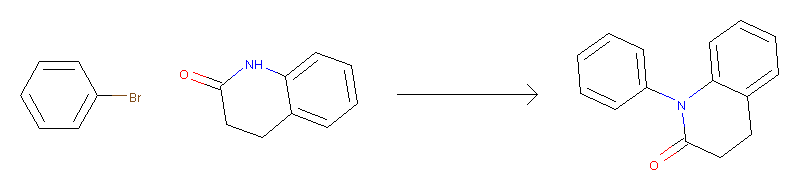



--------------------------------------------------

RANK 1 PRECEDENT
PRODUCT MATCH SCORE: 0.5616438356164384


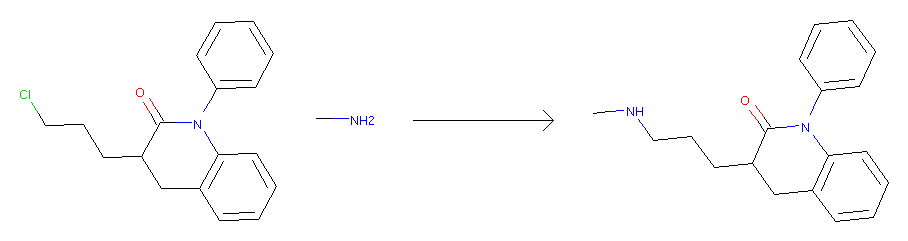

-> template: ([CH2;+0:1]-[NH;+0:2])>>Cl-[CH2;+0:1].[NH2;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 2 PRECEDENT
PRODUCT MATCH SCORE: 0.5285714285714286


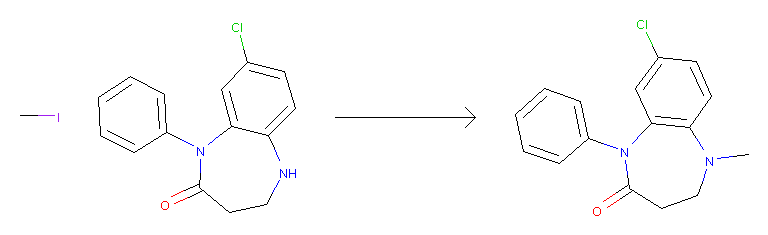

-> template: ([CH3;+0:1]-[N;H0;+0:2])>>I-[CH3;+0:1].[NH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 3 PRECEDENT
PRODUCT MATCH SCORE: 0.4666666666666667


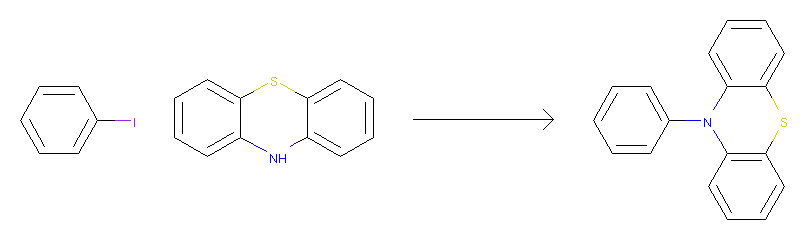

-> template: ([N;H0;+0:1]-[c;H0;+0:2])>>I-[c;H0;+0:2].[NH;+0:1]
Precursor similarity 0.32558139534883723, overall 0.15193798449612406, smiles O=C(CCc1ccccc1I)Nc1ccccc1


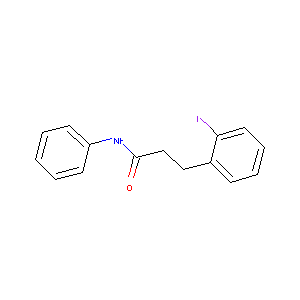

Precursor similarity 0.4805194805194805, overall 0.22424242424242424, smiles Ic1ccccc1.O=C1CCc2ccccc2N1


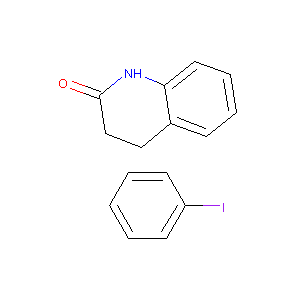



--------------------------------------------------

RANK 4 PRECEDENT
PRODUCT MATCH SCORE: 0.45714285714285713


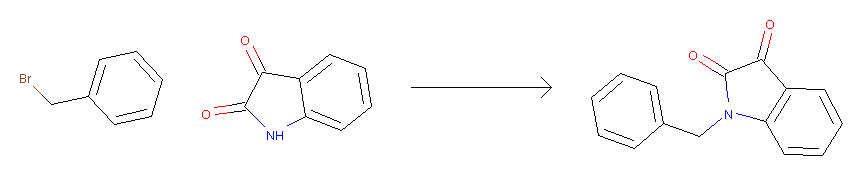

-> template: ([CH2;+0:1]-[N;H0;+0:2])>>Br-[CH2;+0:1].[NH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 5 PRECEDENT
PRODUCT MATCH SCORE: 0.45714285714285713


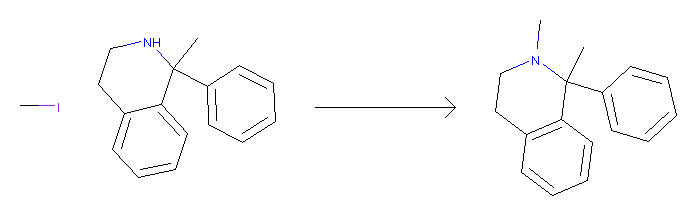

-> template: ([CH3;+0:1]-[N;H0;+0:2])>>I-[CH3;+0:1].[NH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 6 PRECEDENT
PRODUCT MATCH SCORE: 0.4533333333333333


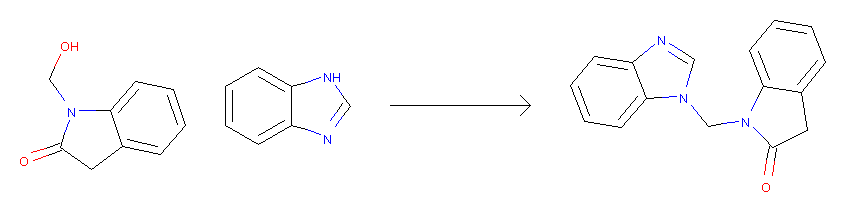

-> template: ([CH2;+0:1]-[n;H0;+0:2])>>O-[CH2;+0:1].[nH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 7 PRECEDENT
PRODUCT MATCH SCORE: 0.4142857142857143


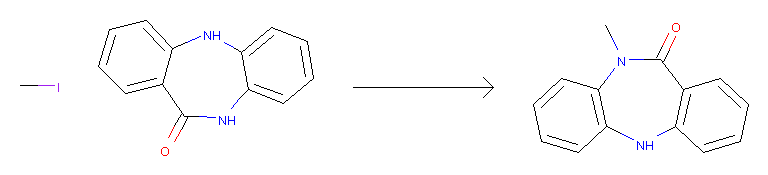

-> template: ([CH3;+0:1]-[N;H0;+0:2])>>I-[CH3;+0:1].[NH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 8 PRECEDENT
PRODUCT MATCH SCORE: 0.4125


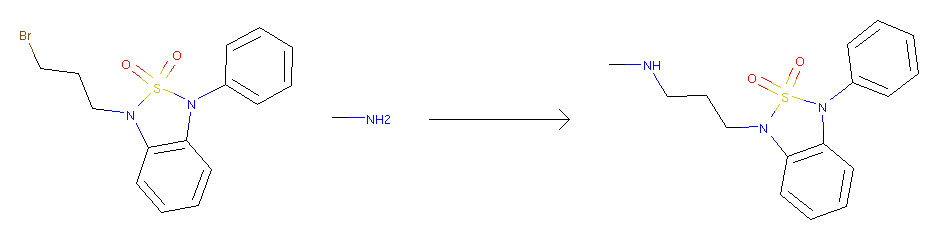

-> template: ([CH2;+0:1]-[NH;+0:2])>>Br-[CH2;+0:1].[NH2;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 9 PRECEDENT
PRODUCT MATCH SCORE: 0.4111111111111111


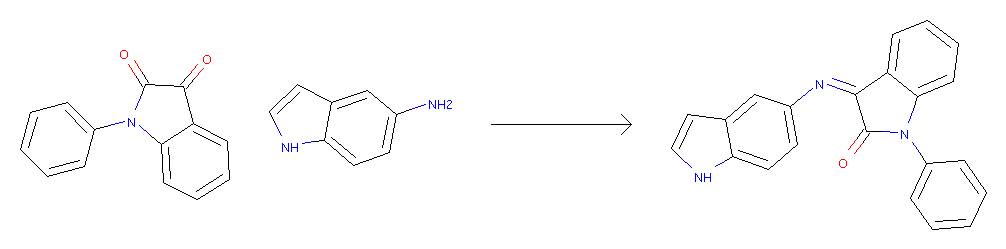

-> template: ([C;H0;+0:1]=[N;H0;+0:2])>>O=[C;H0;+0:1].[NH2;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 10 PRECEDENT
PRODUCT MATCH SCORE: 0.4090909090909091


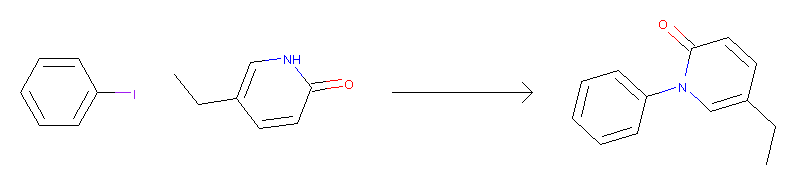

-> template: ([c;H0;+0:1]-[n;H0;+0:2])>>I-[c;H0;+0:1].[nH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 11 PRECEDENT
PRODUCT MATCH SCORE: 0.4084507042253521


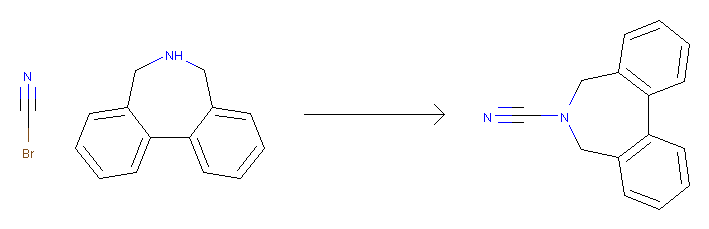

-> template: ([C;H0;+0:1]-[N;H0;+0:2])>>Br-[C;H0;+0:1].[NH;+0:2]
Precursor similarity 0.3037974683544304, overall 0.12408628989124622, smiles O=C(Br)CCc1ccccc1Nc1ccccc1


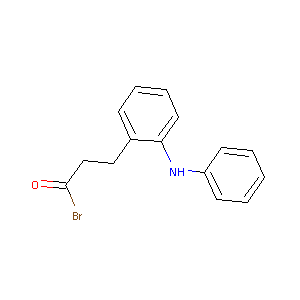



--------------------------------------------------

RANK 12 PRECEDENT
PRODUCT MATCH SCORE: 0.40789473684210525


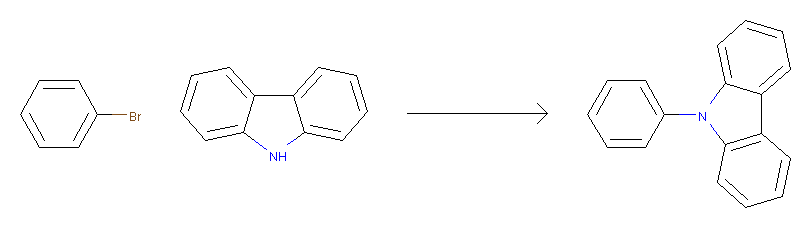

-> template: ([c;H0;+0:1]-[n;H0;+0:2])>>Br-[c;H0;+0:1].[nH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 13 PRECEDENT
PRODUCT MATCH SCORE: 0.40298507462686567


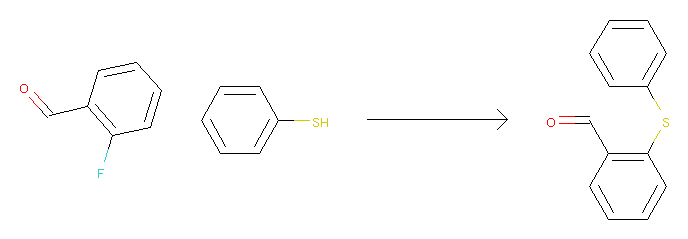

-> template: ([S;H0;+0:1]-[c;H0;+0:2])>>F-[c;H0;+0:2].[SH;+0:1]
No precursors could be generated!


--------------------------------------------------

RANK 14 PRECEDENT
PRODUCT MATCH SCORE: 0.4


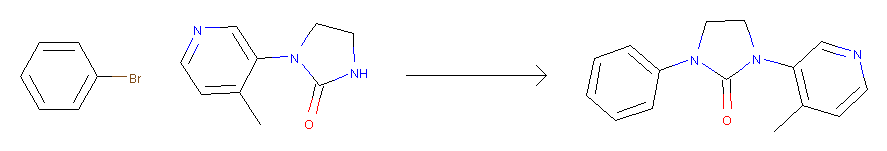

-> template: ([N;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].[NH;+0:1]
Precursor similarity 0.26744186046511625, overall 0.10697674418604651, smiles O=C(CCc1ccccc1Br)Nc1ccccc1


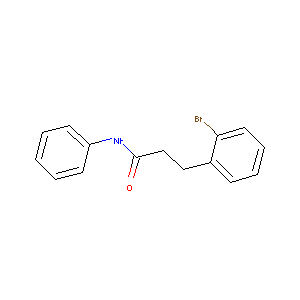

Precursor similarity 0.4155844155844156, overall 0.16623376623376626, smiles Brc1ccccc1.O=C1CCc2ccccc2N1


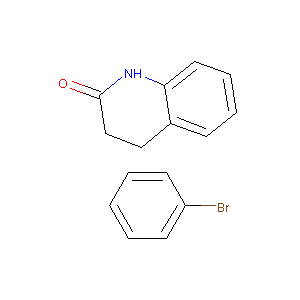



--------------------------------------------------

RANK 15 PRECEDENT
PRODUCT MATCH SCORE: 0.3977272727272727


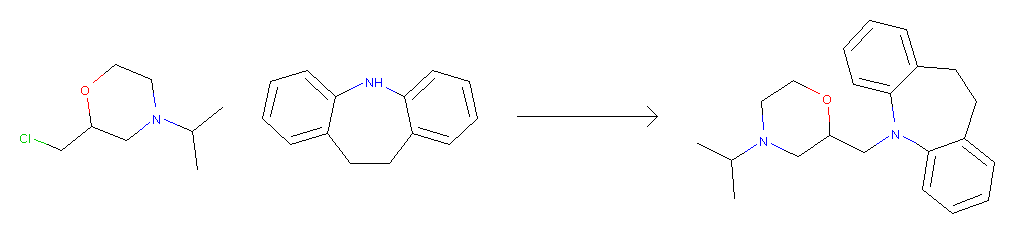

-> template: ([CH2;+0:1]-[N;H0;+0:2])>>Cl-[CH2;+0:1].[NH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 16 PRECEDENT
PRODUCT MATCH SCORE: 0.3977272727272727


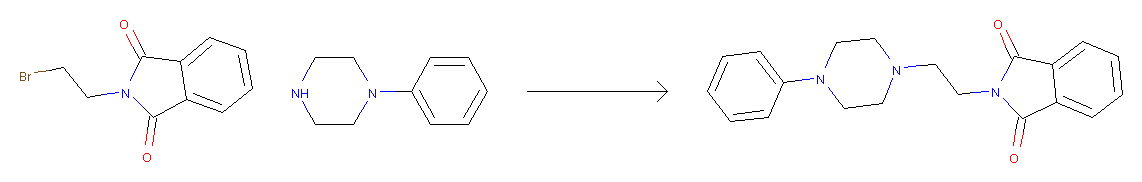

-> template: ([CH2;+0:1]-[N;H0;+0:2])>>Br-[CH2;+0:1].[NH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 17 PRECEDENT
PRODUCT MATCH SCORE: 0.39759036144578314


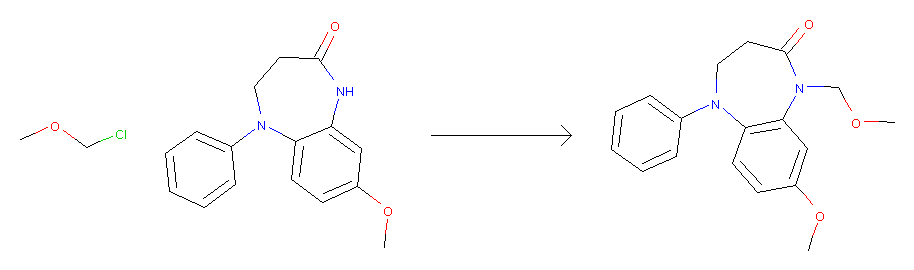

-> template: ([CH2;+0:1]-[N;H0;+0:2])>>Cl-[CH2;+0:1].[NH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 18 PRECEDENT
PRODUCT MATCH SCORE: 0.39759036144578314


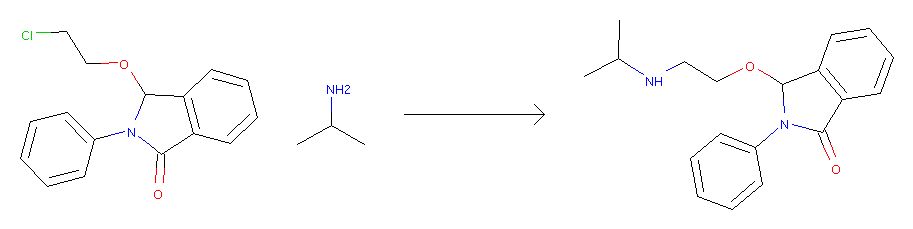

-> template: ([CH2;+0:1]-[NH;+0:2])>>Cl-[CH2;+0:1].[NH2;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 19 PRECEDENT
PRODUCT MATCH SCORE: 0.39759036144578314


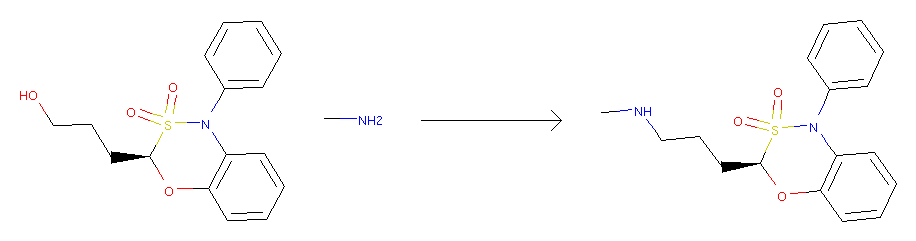

-> template: ([CH2;+0:1]-[NH;+0:2])>>O-[CH2;+0:1].[NH2;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 20 PRECEDENT
PRODUCT MATCH SCORE: 0.3974358974358974


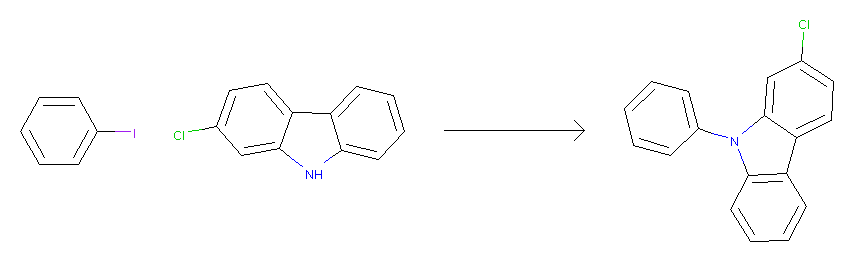

-> template: ([c;H0;+0:1]-[n;H0;+0:2])>>I-[c;H0;+0:1].[nH;+0:2]
No precursors could be generated!


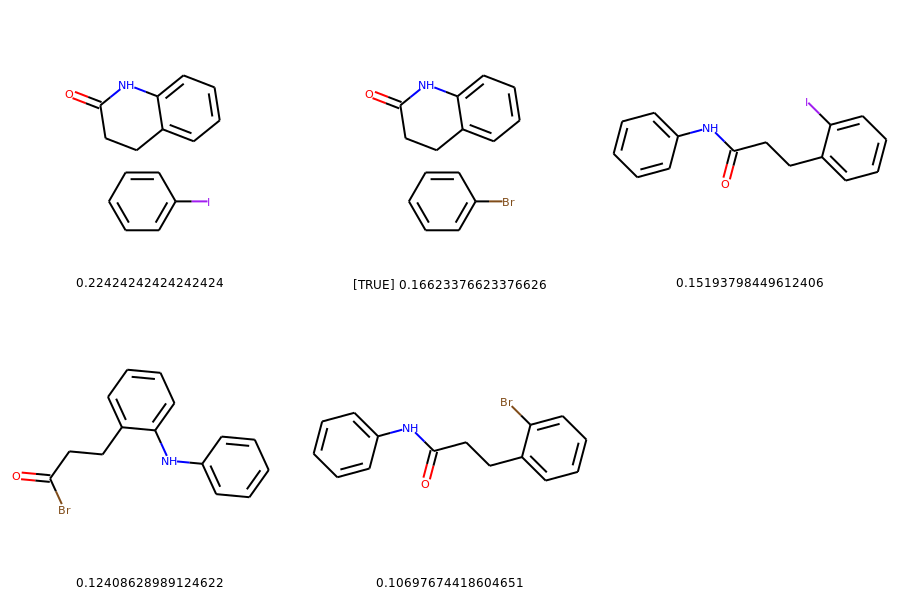

Ic1ccccc1.O=C1CCc2ccccc2N1
Brc1ccccc1.O=C1CCc2ccccc2N1
O=C(CCc1ccccc1I)Nc1ccccc1
O=C(Br)CCc1ccccc1Nc1ccccc1
O=C(CCc1ccccc1Br)Nc1ccccc1
O=C1CCc2ccccc2N1c1ccccc1
True reaction:Br[c:1]1[cH:2][cH:3][cH:4][cH:5][cH:6]1.[O:7]=[C:8]1[CH2:9][CH2:10][c:11]2[cH:12][cH:13][cH:14][cH:15][c:16]2[NH:17]1>>[c:1]1([N:17]2[C:8](=[O:7])[CH2:9][CH2:10][c:11]3[cH:12][cH:13][cH:14][cH:15][c:16]32)[cH:2][cH:3][cH:4][cH:5][cH:6]1
prec_goal: Brc1ccccc1.O=C1CCc2ccccc2N1

Reaction precedent 1, prod similarity 0.5616438356164384
-> rxn_smiles Cl[CH2:1][CH2:2][CH2:3][CH:4]1[C:5](=[O:6])[N:7]([c:8]2[cH:9][cH:10][cH:11][cH:12][cH:13]2)[c:14]2[c:15]([cH:16][cH:17][cH:18][cH:19]2)[CH2:20]1.[CH3:21][NH2:22]>>[CH2:1]([CH2:2][CH2:3][CH:4]1[C:5](=[O:6])[N:7]([c:8]2[cH:9][cH:10][cH:11][cH:12][cH:13]2)[c:14]2[c:15]([cH:16][cH:17][cH:18][cH:19]2)[CH2:20]1)[NH:22][CH3:21]
-> template: ([CH2;+0:1]-[NH;+0:2])>>Cl-[CH2;+0:1].[NH2;+0:2]

Reaction precedent 2, prod similarity 0.5285714285714286
-> rxn_smiles I[CH3:1].[O:2]=[C:3]1

NameError: name 'raw_input' is not defined

In [11]:
inputs = list(datasub_val.index)
do_one(inputs[32], debug=True, draw=True, max_prec=20)